In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import math
import matplotlib.pyplot as plt
import datetime
from datetime import date
from tqdm.notebook import tqdm

### Input Variables Variables

In [2]:
start_year = 2001
end_year   = 2020
indicator  = "ROCE"
n = 30
transaction_cost = 0.1
capital = 1000000
compounded_capital = capital
initial_capital   = capital

f_path = r"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\CSV\All Fundamental Data.csv"
c_path  = r"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\CSV\All Close Prices.csv"

### Reading Main files

In [3]:
fdf = pd.read_csv(f_path)
cdf = pd.read_csv(c_path)

In [4]:
fdf.drop(columns=['Unnamed: 0'],inplace=True)
cdf.drop(columns=['Unnamed: 0'],inplace=True)

----

### Starting Year wise Loop
Get Trade Sheet

In [5]:
# Blank Dataframe to store Yearly Tradesheet
change = pd.DataFrame()

for year in tqdm(range(start_year, end_year+1)):
    
    f1 = fdf[fdf['Year']==year]
    
    # Fundamental Conditions
    conditions = ["Shareholder's Funds", "PAT", "PBIT"]
    
    for condition in conditions:
        f1 = f1[f1.fillna(0)[condition] > 0]
    
    # Market Cap Condition
    f1 = f1[f1['Market Cap']>=100]
    
    cdf['Date'] = pd.to_datetime(cdf['Date'])
    cdf['Year'] = cdf['Date'].dt.year
    
    # Indicator Conditions
    if indicator == "ROCE" :
        
        # Remove Banking stocks in ROCE
        f1 = f1[~f1['Name'].str.contains('Bank')]
        
        # ROCE Formula
        f1[indicator] = (f1['PBIT'].fillna(0) / (f1["Shareholder's Funds"].fillna(0) + f1["Long Term Borrowings"].fillna(0) + f1["Short Term Borrowings"].fillna(0)))*100

    elif indicator == "ROE" :
        
        # ROE Formula
        f1[indicator] = (f1['PAT'].fillna(0) / f1["Shareholder's Funds"].fillna(0))*100
        
        
    # New dataframe to store calculations 
    f2 = f1[['Name',indicator]]                                                            # Name, Indicator
    f2['Buy Date'] = date(year+1,7,1)                                                        # Buy Date
    
    # Dataframe of companies containing closings on 1st July of start year & next year
    cnam  = cdf[cdf['Date'] == f'{year+1}-07-01']
    cnam2 = cdf[cdf['Date'] == f'{year+2}-07-01']
    
    
    # Reset Indexes
    f2.reset_index(drop=True,inplace=True)
    cnam.reset_index(drop=True,inplace=True)
    
    
    # Adding Closing Prices of Start year (Buying Price) and dropping companies with no Closing prices 
    f2 = pd.merge(f2,cnam[['Name','Close']], how='left',on='Name').dropna()
    f2.rename(columns={'Close':'Close1'},inplace=True)
    f2 = f2.sort_values(by=['ROCE'], ascending=False)
    
    f2.reset_index(drop=True,inplace=True)                                                 # Reset Indexes
    
    # Adding Selling Date
    f2['Sell Date'] = date(year+2,7,1)
    
    # Adding Closing Prices of Next year (Selling Price) and dropping companies with no Closing prices 
    f2 = pd.merge(f2,cnam2[['Name','Close']], how='left',on='Name')
    f2.rename(columns={'Close':'Close2'},inplace=True)                                     # Reset Indexes
    
    # New Dataframe to store Top n Companies and Find Quantity
    f3 = f2[:30]
    
    # Filling companies with no Selling Prices with last present close and update the Selling Dates
    for i in range(f3.shape[0]):
        if f3.fillna(0)['Close2'].iloc[i] == 0 :
            f3['Close2'].iloc[i] = cdf[(cdf['Name']==f3['Name'].iloc[i]) & (cdf['Date'] < f'{year+2}-07-01')]['Close'].iloc[0]
            f3['Sell Date'].iloc[i] = cdf[(cdf['Name']==f3['Name'].iloc[i]) & (cdf['Date'] < f'{year+2}-07-01')]['Date'].iloc[0].date()
    
    # Claculating Quantity
    f3['Qty'] = capital/(n*f3['Close1'])
    
    # Defining a function for Roundown
    def Floor(x):
        try:
            return math.floor(x)
        except:
            return(x)
    
    # Rounddown Quantity
    f3['Qty'] = f3['Qty'].apply(Floor)
    
    # Buying & Selling Value = Qty x Close Price
    f3['Buy Value'] = f3['Qty']*f3['Close1']
    f3['Sell Value'] = f3['Qty']*f3['Close2']
    
    f3['% Change'] = (f3['Close2'] / f3['Close1'] - 1)*100
    
    f3['Transaction Cost'] = (transaction_cost / 100)*(f3['Buy Value']+f3['Sell Value'])
    
    #print(f"{year} Starting Capital is {capital}")
    
    capital = f3['Sell Value'].sum() - f3['Transaction Cost'].sum()
    
    #print(f"{year} Ending Capital is {capital}")
    
    change = change.append(f3)
    
#display(change)    

  0%|          | 0/20 [00:00<?, ?it/s]

----

,Name,ROCE,Buy Date,Close1,Sell Date,Close2,Qty,Buy Value,Sell Value,% Change,Transaction Cost
0,Nestle India Ltd.,66.050196,2002-07-01,509.200000,2003-07-01,570.050000,65,3.309800e+04,3.705325e+04,11.950118,70.151250
1,Wockhardt Ltd.,36.934559,2002-07-01,150.120584,2003-07-01,109.083630,222,3.332677e+04,2.421657e+04,-27.335994,57.543336
2,Maharashtra Seamless Ltd.,36.864613,2002-07-01,28.175000,2003-07-01,43.900000,1183,3.333103e+04,5.193370e+04,55.811890,85.264725
3,Asian Paints Ltd.,35.169218,2002-07-01,22.286667,2003-07-01,25.486667,1495,3.331857e+04,3.810257e+04,14.358361,71.421133
4,Sun Pharmaceutical Industries Ltd.,34.603900,2002-07-01,13.907500,2003-07-01,32.575000,2396,3.332237e+04,7.804970e+04,134.226137,111.372070
...,...,...,...,...,...,...,...,...,...,...,...
25,Ajanta Soya Ltd.,51.640576,2021-07-01,22.840000,2022-03-31,38.720000,46680,1.066171e+06,1.807450e+06,69.527145,2873.620800
26,Accelya Solutions India Ltd.,51.432350,2021-07-01,1185.100000,2022-03-31,928.000000,899,1.065405e+06,8.342720e+05,-21.694372,1899.676900
27,TAAL Enterprises Ltd.,51.384390,2021-07-01,639.650000,2022-03-31,1631.250000,1666,1.065657e+06,2.717662e+06,155.022278,3783.319400
28,Tata Consultancy Services Ltd.,51.365798,2021-07-01,3341.500000,2022-03-31,3739.950000,319,1.065938e+06,1.193044e+06,11.924286,2258.982550



TOP WINNERS


,Name,Buy Date,% Change
7,Capri Global Capital Ltd.,2009-07-01,417.645380
16,JM Financial Ltd.,2005-07-01,337.226277
28,Alkyl Amines Chemicals Ltd.,2020-07-01,327.409117
25,Mayur Uniquoters Ltd.,2013-07-01,252.545496
12,RHI Magnesita India Ltd.,2013-07-01,251.782364
11,TTK Prestige Ltd.,2010-07-01,240.379754
9,Tata Metaliks Ltd.,2015-07-01,234.551657
29,MPS Ltd.,2013-07-01,233.625461
18,Ashapura Minechem Ltd.,2020-07-01,230.021598
6,Indiamart Intermesh Ltd.,2020-07-01,223.082839



TOP LOSERS


,Name,Buy Date,% Change
12,Capri Global Capital Ltd.,2010-07-01,-88.857609
20,Fourth Dimension Solutions Ltd.,2018-07-01,-87.692308
16,Spectacle Ventures Ltd.,2010-07-01,-87.167806
20,Morepen Laboratories Ltd.,2002-07-01,-76.895629
0,Sandur Manganese & Iron Ores Ltd.,2008-07-01,-72.846139
5,Eon Electric Ltd.,2011-07-01,-70.797011
5,Suumaya Industries Ltd.,2021-07-01,-69.735500
29,Viaan Industries Ltd.,2018-07-01,-69.611111
12,Coforge Ltd.,2007-07-01,-66.074196
19,Paul Merchants Ltd.,2018-07-01,-65.376787


  0%|          | 0/20 [00:00<?, ?it/s]


Daily Portfolio Value


,Date,PV
0,2022-06-30 00:00:00,36516202.489676
1,2022-06-29 00:00:00,36516202.489676
2,2022-06-28 00:00:00,36516202.489676
3,2022-06-27 00:00:00,36516202.489676
4,2022-06-26 00:00:00,36516202.489676
...,...,...
360,2002-07-05 00:00:00,1020251.319853
361,2002-07-04 00:00:00,1008606.302094
362,2002-07-03 00:00:00,1005783.316244
363,2002-07-02 00:00:00,1000560.689708


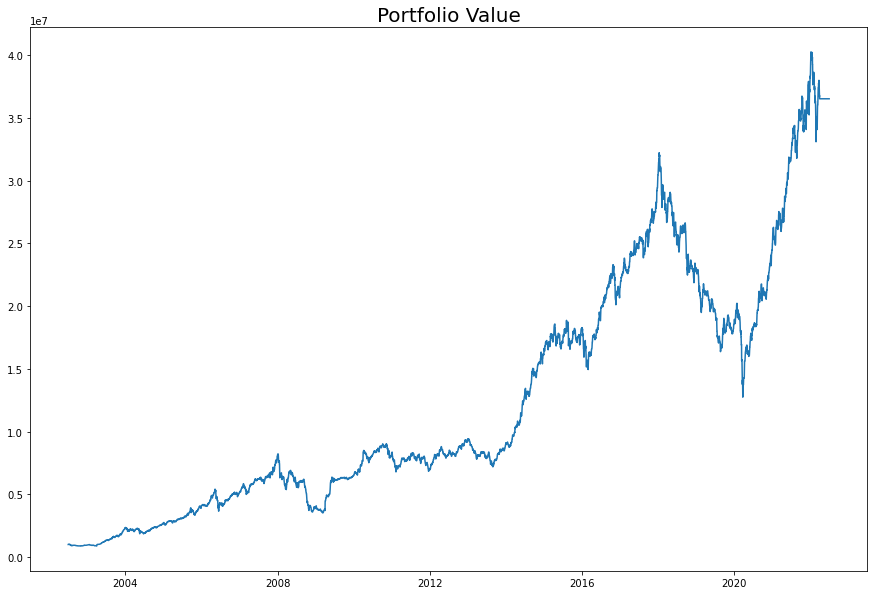

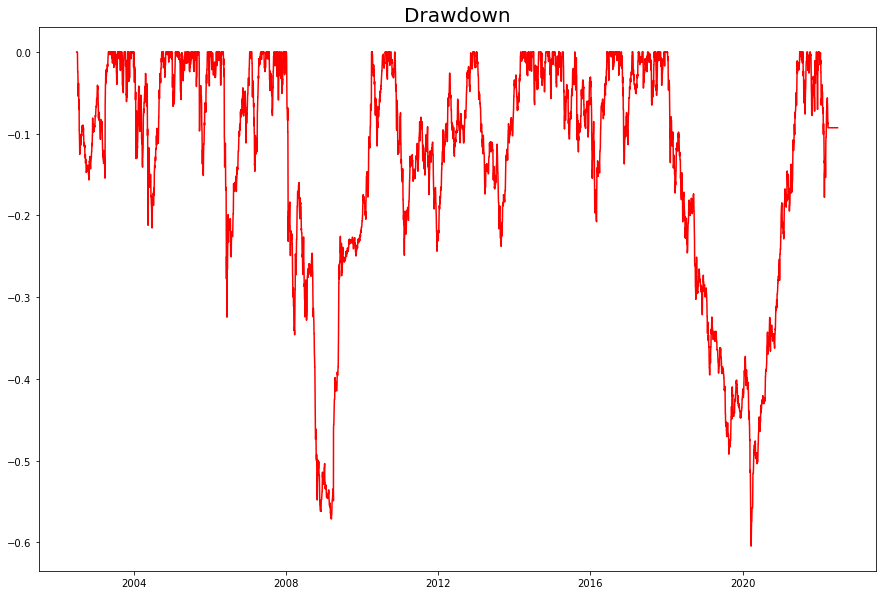

,CAGR,Trading Edge,MDD,CAR/MDD
0,19.697074,22.840307,-60.45856,0.325795


In [6]:
display(change)

# TOP n Winners & Losers

winners = change.sort_values(by="% Change", ascending=False)[['Name','Buy Date','% Change']]
losers = change.sort_values(by="% Change", ascending=True)[['Name','Buy Date','% Change']]
winners.reset_index(drop=)


winners_counts = change[change['% Change']>0].shape[0] / change.shape[0]
losers_counts  = change[change['% Change']<0].shape[0] / change.shape[0]

avg_win  = change[change['% Change']>0]['% Change'].mean()
avg_loss = change[change['% Change']<0]['% Change'].mean()


print("\nTOP WINNERS")
display(winners[:20])

print("\nTOP LOSERS")
display(losers[:20])




# Finding Daily Portfolio Value

k = 0

combined_PV = pd.DataFrame(columns=['Date','PV'])

for year in tqdm(range(start_year,end_year+1)):
    
    #print(year)
    multipv = pd.DataFrame(columns=['Date','PV'])
    multipv['Date'] = pd.date_range(f'{year+1}-07-01',f'{year+2}-06-30').sort_values(ascending=False)
    multipv['PV'].fillna(0,inplace=True)

    for i in range(k,n+k):

        pv1 = cdf[(cdf['Name']==change['Name'].iloc[i]) & (cdf['Date'] >= f'{year+1}-07-01') & (cdf['Date'] < f'{year+2}-07-01')]

        pv1 = pv1[['Name','Date','Close']]
        pv1.reset_index(drop=True, inplace = True)

        all_dates = pd.DataFrame(columns=['Name','Date','Close'])
        all_dates['Date'] = pd.date_range(f'{year+1}-07-01',f'{year+2}-06-30').sort_values(ascending=False)
        
        
        
        for j in range(all_dates.shape[0]):
            if all_dates['Date'].iloc[j] not in pv1['Date'].tolist():
                pv1 = pv1.append(all_dates.iloc[j])

                
        pv1.sort_values(by='Date', ascending=False, inplace=True) 
        pv1.reset_index(drop=True, inplace = True)
        
        pv1 = pv1[['Name','Date','Close']].bfill().ffill()
        pv1.reset_index(drop=True, inplace = True)
        
        pv1['PV'] = pv1['Close']*change['Qty'].iloc[i]

        multipv['PV'] = np.where(multipv['Date'] == pv1['Date'], multipv['PV']+pv1['PV'], np.nan)

    combined_PV = multipv.append(combined_PV)
    k += n

print("\nDaily Portfolio Value")
display(combined_PV)

print()



combined_PV = combined_PV.sort_values(by='Date', ascending=True)
combined_PV['MDD'] = (combined_PV['PV']/combined_PV['PV'].rolling(len(combined_PV),1).max())-1
combined_PV = combined_PV.sort_values(by='Date',ascending=False)
combined_PV.reset_index(drop=True,inplace=True)



plt.figure(figsize=(15,10))
plt.plot(combined_PV["Date"],combined_PV["PV"])
plt.title("Portfolio Value", fontsize=20)
plt.show()

plt.figure(figsize=(15,10))
plt.plot(combined_PV["Date"],combined_PV["MDD"],color = 'red')
plt.title("Drawdown", fontsize=20)
plt.show()


# Ratios

tradingedge = winners_counts*avg_win + losers_counts*avg_loss

cagr        = ((capital/initial_capital)**(1/(end_year-start_year+1))-1)*100

mdd         = min(combined_PV['MDD'])*100

calc = pd.DataFrame({"CAGR":[cagr],  "Trading Edge":[tradingedge], "MDD":[mdd], "CAR/MDD":[-cagr/mdd]})

display(calc)

In [10]:
change

,Name,ROCE,Buy Date,Close1,Sell Date,Close2,Qty,Buy Value,Sell Value,% Change,Transaction Cost
0,Nestle India Ltd.,66.050196,2002-07-01,509.200000,2003-07-01,570.050000,65,3.309800e+04,3.705325e+04,11.950118,70.151250
1,Wockhardt Ltd.,36.934559,2002-07-01,150.120584,2003-07-01,109.083630,222,3.332677e+04,2.421657e+04,-27.335994,57.543336
2,Maharashtra Seamless Ltd.,36.864613,2002-07-01,28.175000,2003-07-01,43.900000,1183,3.333103e+04,5.193370e+04,55.811890,85.264725
3,Asian Paints Ltd.,35.169218,2002-07-01,22.286667,2003-07-01,25.486667,1495,3.331857e+04,3.810257e+04,14.358361,71.421133
4,Sun Pharmaceutical Industries Ltd.,34.603900,2002-07-01,13.907500,2003-07-01,32.575000,2396,3.332237e+04,7.804970e+04,134.226137,111.372070
...,...,...,...,...,...,...,...,...,...,...,...
25,Ajanta Soya Ltd.,51.640576,2021-07-01,22.840000,2022-03-31,38.720000,46680,1.066171e+06,1.807450e+06,69.527145,2873.620800
26,Accelya Solutions India Ltd.,51.432350,2021-07-01,1185.100000,2022-03-31,928.000000,899,1.065405e+06,8.342720e+05,-21.694372,1899.676900
27,TAAL Enterprises Ltd.,51.384390,2021-07-01,639.650000,2022-03-31,1631.250000,1666,1.065657e+06,2.717662e+06,155.022278,3783.319400
28,Tata Consultancy Services Ltd.,51.365798,2021-07-01,3341.500000,2022-03-31,3739.950000,319,1.065938e+06,1.193044e+06,11.924286,2258.982550


### Output Variables

* change : Tradelist
* combined_PV : Daily Portfolio Value
* winners : All Winners in descending
* losers : All Losers in ascending
* cagr : CAGR
* tradingedge : Trading Edge
* mdd : Max Drawdown